In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [8]:
df = pd.read_csv(
    "OnlineRetail.csv",
    encoding="ISO-8859-1"       
)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [9]:
df = df.dropna(subset=["CustomerID"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%d-%m-%Y %H:%M")
df["CustomerID"] = df["CustomerID"].astype(int)

In [10]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [11]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

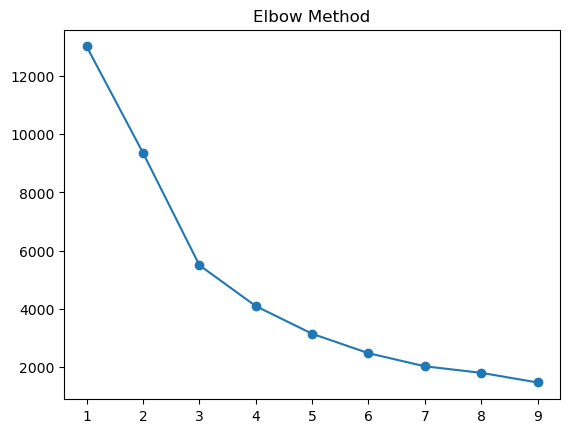

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title("Elbow Method")
plt.show()

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

In [16]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Xem kết quả
print(rfm.head())

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346           326          1  77183.60        3
12347             2          7   4310.00        0
12348            75          4   1797.24        0
12349            19          1   1757.55        0
12350           310          1    334.40        1


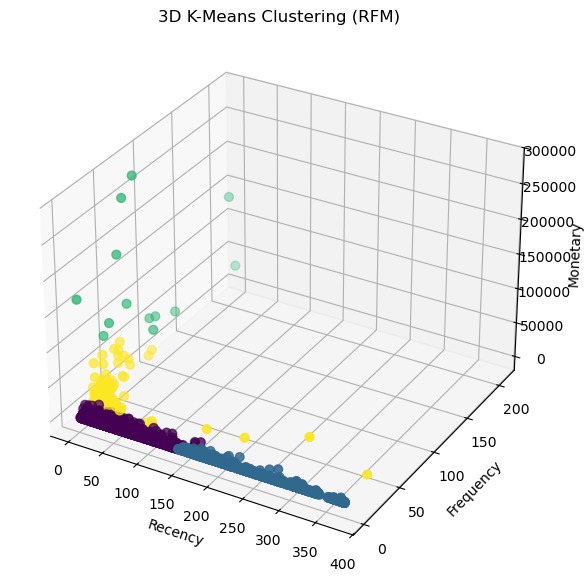

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    rfm["Recency"],
    rfm["Frequency"],
    rfm["Monetary"],
    c=rfm["Cluster"],
    s=40
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D K-Means Clustering (RFM)")
plt.show()
